# Combineed results visualization

Successfully plotted: split-gp-2.30 (X: 'p', Y: 'selective_acc') from results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_801_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_2.30_gamma_0.2_lambda_split_0.5.csv
Successfully plotted: Personalized via FL (X: 'p', Y: 'Personalized') from results/splitgp_vgg11_results_CIFAR10_method_personalized_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/personalized.csv
Error: Columns ('p' or 'Genere') not found in file: results/splitgp_vgg11_results_CIFAR10_method_fedavg_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/fedavg_global.csv. Please check your configuration.
Successfully plotted: Multi-Exit NN via FL/SL (X: 'p', Y: 'selective_acc') from results/splitgp_vgg11_results_CIFAR10_method_multi-exit_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.0_ETH_0.2/multi-exit_combined_results_eth_3.00_gamma_0.5_lambda_s

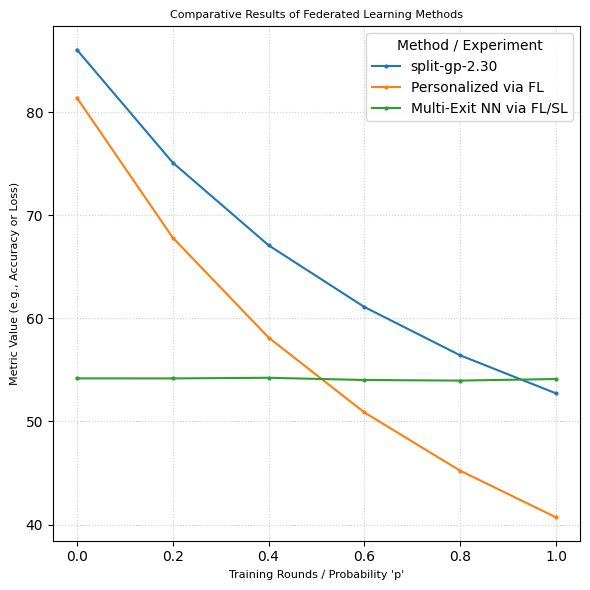


✅ Plot successfully saved as: final_comparison_plot.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

def plot_heterogeneous_csvs_line(config_list, title="Comparative Results", xlabel="X-Axis", ylabel="Y-Axis", save_filename="comparison_plot.png"):
    """
    Reads multiple CSV files, each with potentially different column names,
    and plots them on the same figure using a provided configuration.

    Args:
        config_list (list): A list of dictionaries, where each dictionary
                            defines one line to plot.
                            Required keys in each dict: 'path', 'x_col', 'y_col', 'legend'.
        title (str): The main title for the plot.
        xlabel (str): The label for the X-axis.
        ylabel (str): The label for the Y-axis.
        save_filename (str): The filename to save the resulting plot image.
    """
    # 1. Setup the plot
    plt.figure(figsize=(6, 6))

    # Track files plotted for confirmation
    plotted_count = 0

    # 2. Iterate over the configuration list and plot
    for config in config_list:
        file_path = config.get('path')
        x_column = config.get('x_col')
        y_column = config.get('y_col')
        legend_label = config.get('legend')

        # Basic input validation
        if not all([file_path, x_column, y_column, legend_label]):
            print(f"Skipping entry: Configuration is missing one or more of 'path', 'x_col', 'y_col', or 'legend'. Config: {config}")
            continue

        try:
            # Read the CSV file
            df = pd.read_csv(file_path)

            # --- Data Preprocessing (Optional but recommended for consistency) ---
            # Attempt to convert X and Y columns to numeric, coercing errors to NaN
            df[x_column] = pd.to_numeric(df[x_column], errors='coerce')
            df[y_column] = pd.to_numeric(df[y_column], errors='coerce')
            # Drop rows where the key data is missing after conversion
            df.dropna(subset=[x_column, y_column], inplace=True)

            # --- Plotting ---
            plt.plot(df[x_column], df[y_column]*100, label=legend_label, marker='.', markersize=4, linestyle='-')
            print(f"Successfully plotted: {legend_label} (X: '{x_column}', Y: '{y_column}') from {file_path}")
            plotted_count += 1

        except FileNotFoundError:
            print(f"Error: File not found at path: {file_path}")
        except KeyError:
            print(f"Error: Columns ('{x_column}' or '{y_column}') not found in file: {file_path}. Please check your configuration.")
        except Exception as e:
            print(f"An unexpected error occurred while processing {file_path}: {e}")


    # 3. Finalize and save the plot
    if plotted_count > 0:
        plt.title(title, fontsize=8)
        plt.xlabel(xlabel, fontsize=8)
        plt.ylabel(ylabel, fontsize=8)
        plt.legend(title="Method / Experiment", loc='best', fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.savefig(save_filename) # Save the figure instead of showing it
        plt.show()

        # plt.close() # Close the figure to free memory
        print(f"\n✅ Plot successfully saved as: {save_filename}")
    else:
        print("\n❌ No data was successfully plotted. Please check your file paths and column names.")

# ====================================================================
#  >>> HOW TO USE THE FUNCTION <<<
# ====================================================================

# 1. **Define your configuration list**
#    - You MUST change the values below to match your files and desired plot!
config_for_plot = [
     {
        'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_801_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_2.30_gamma_0.2_lambda_split_0.5.csv',
        'x_col': 'p',
        'y_col': 'selective_acc',
        'legend': 'split-gp-2.30',
    },
     {
        'path': 'results/splitgp_vgg11_results_CIFAR10_method_personalized_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/personalized.csv',
        'x_col': 'p', # X-axis column in this file is 'p' (from your image)
        'y_col': 'Personalized', # Y-axis column in this file is 'Multi-Exit' (from your image)
        'legend': 'Personalized via FL', # Custom legend label
    },
     {
        'path': 'results/splitgp_vgg11_results_CIFAR10_method_fedavg_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/fedavg_global.csv',
        'x_col': 'p', # X-axis column in this file is 'p' (from your image)
        'y_col': 'Genere', # Y-axis column in this file is 'Multi-Exit' (from your image)
        'legend': 'FedAvg', # Custom legend label
    },
    {
        'path': 'results/splitgp_vgg11_results_CIFAR10_method_multi-exit_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.0_ETH_0.2/multi-exit_combined_results_eth_3.00_gamma_0.5_lambda_split_0.0.csv',
        'x_col': 'p', # Example: X-axis column in this file is 'Round'
        'y_col': 'selective_acc', # Example: Y-axis column in this file is 'Global_Accuracy'
        'legend': 'Multi-Exit NN via FL/SL', # Custom legend label
    },

   


    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.05.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-0.05',
    # },
    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.10.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-0.10',
    # },
    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.20.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-0.20',
    # },
    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.40.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-0.40',
    # },
    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.80.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-0.80',
    # },
    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_01.20.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-1.20',
    # },
    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_1.60.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-1.60',
    # },
    # {
    #     'path': 'results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_2.00.csv',
    #     'x_col': 'p',
    #     'y_col': 'selective_acc',
    #     'legend': 'split-gp-2.00',
    # },


]

# 2. **Call the function**
plot_heterogeneous_csvs_line(
    config_list=config_for_plot,
    title="Comparative Results of Federated Learning Methods",
    xlabel="Training Rounds / Probability 'p'", # Use a descriptive label that covers all X-data
    ylabel="Metric Value (e.g., Accuracy or Loss)",
    save_filename="final_comparison_plot.png"
)

In [2]:
0.8 * 100

80.0

# Split GP comparision

Found 23 CSV files to process...


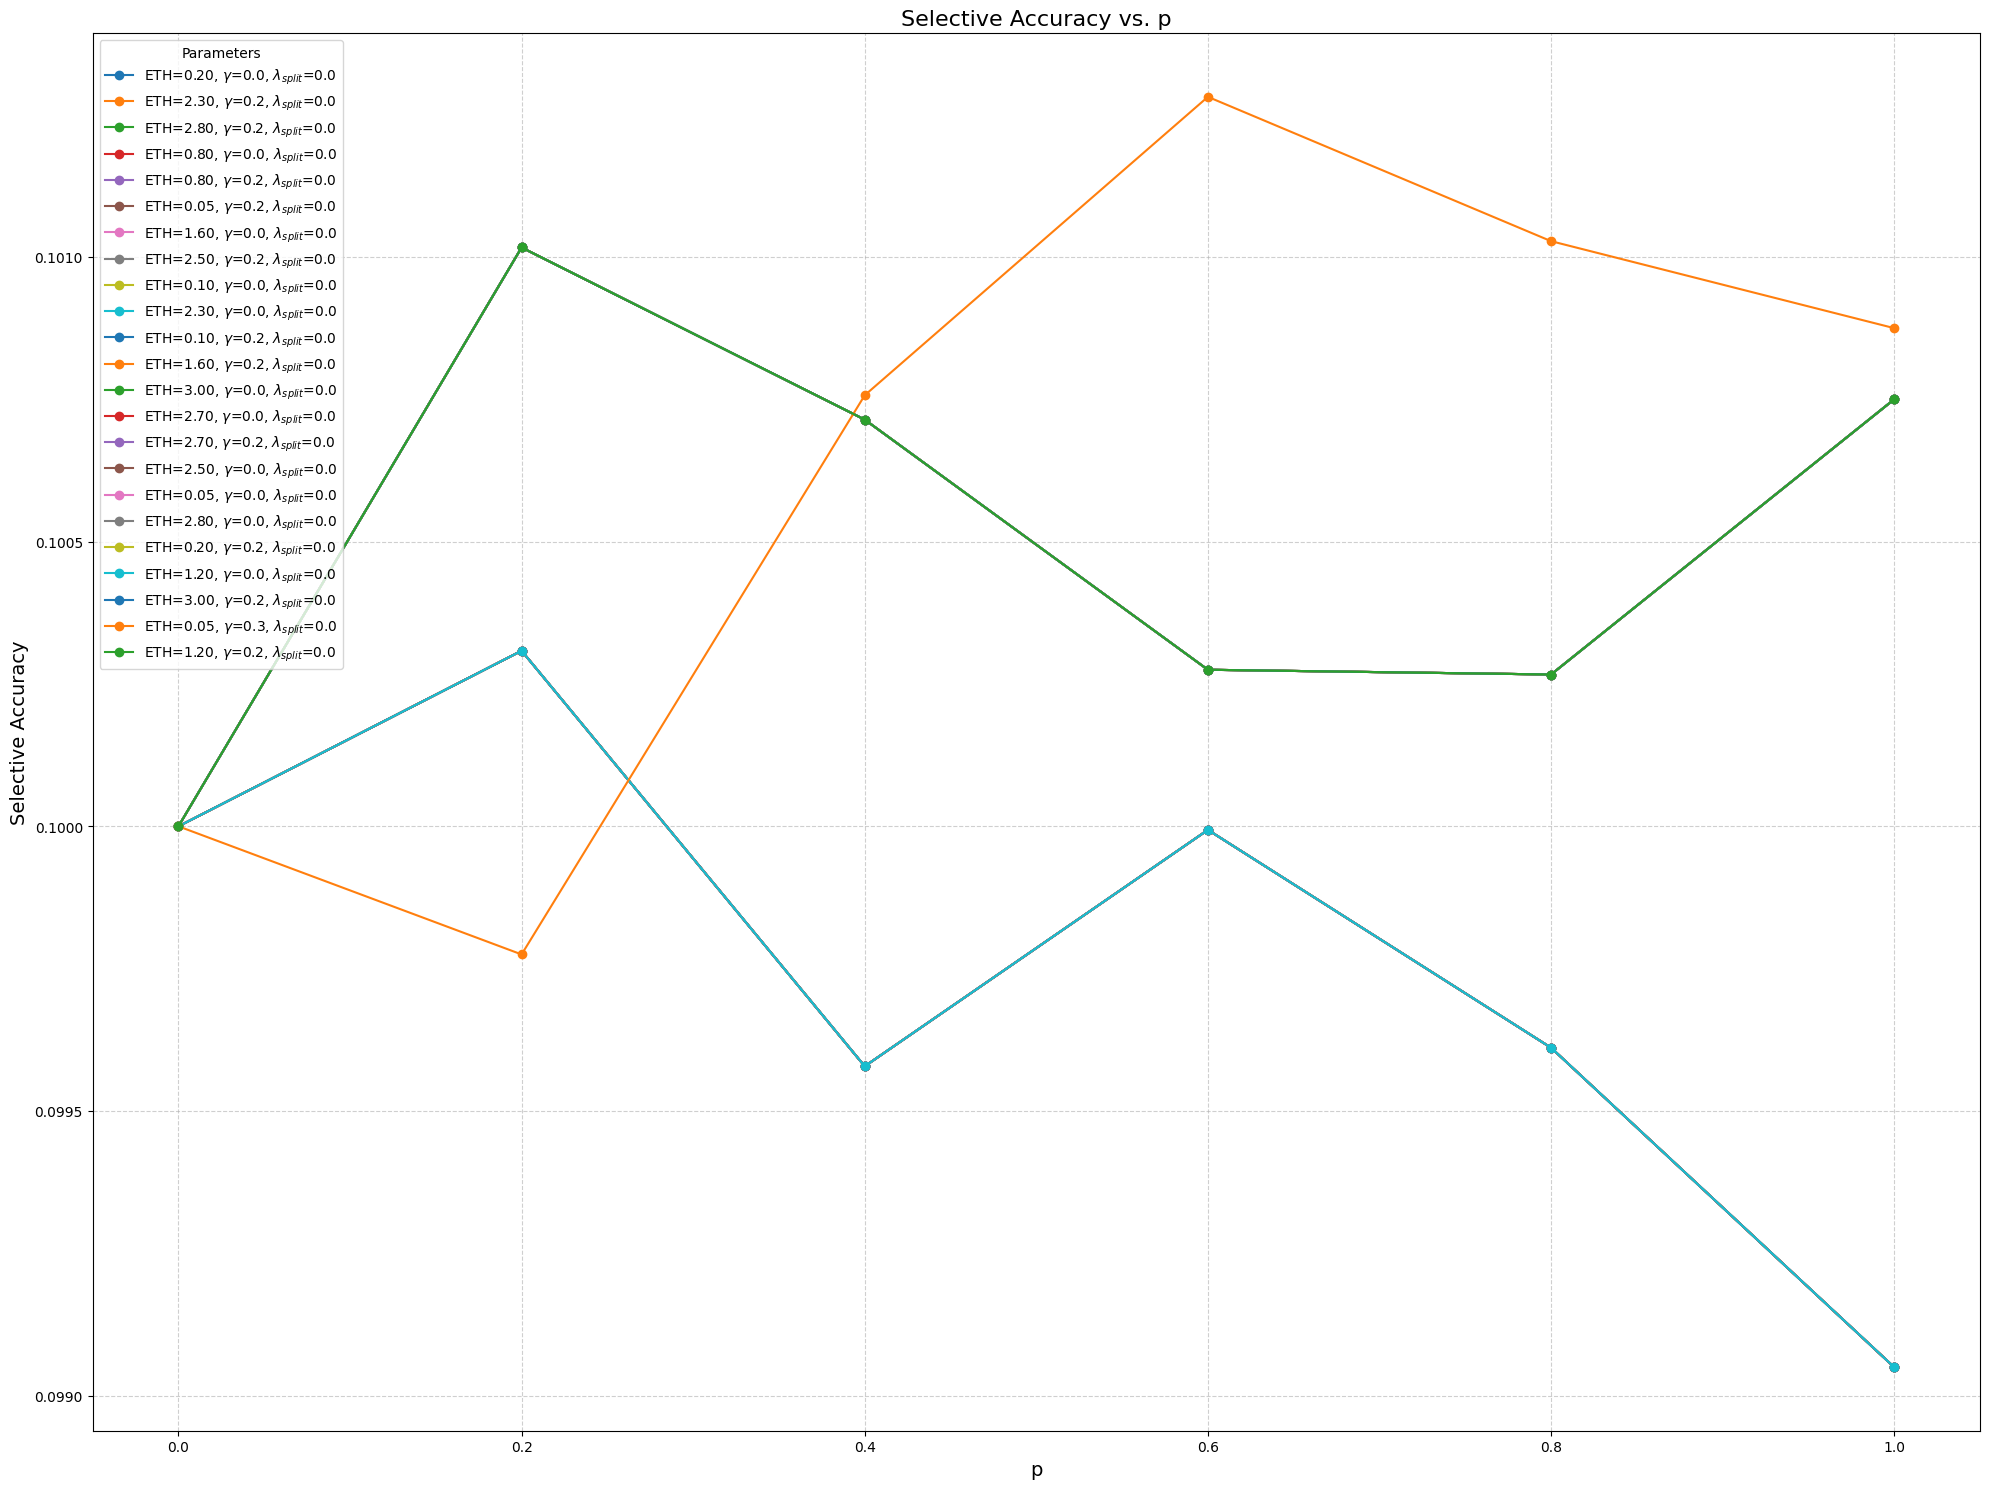

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import glob

# Define the results directory name
results_dir_name = os.path.join("results", "splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_801_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05")
results_dir_name = os.path.join("results", "splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_5_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05")

# --- NEW FUNCTION TO PARSE FILENAME ---
def get_plot_label(filename):
    """
    Extracts eth, gamma, and lambda_split values from the filename and formats a label.
    Example filename: splitgp_combined_results_eth_0.20_gamma_0.0_lambda_split_0.5.csv
    """
    # Regex to capture the three variable parameters
    # The pattern: _param_name_ (value)
    match = re.search(r'eth_(\d+\.?\d*)_gamma_(\d+\.?\d*)_lambda_split_(\d+\.?\d*)', filename)

    if match:
        eth, gamma, lambda_split = match.groups()
        # Format the label using LaTeX for lambda (if you plan to render with LaTeX)
        # Otherwise, plain text: f'ETH={eth}, Gamma={gamma}, Lambda_split={lambda_split}'
        return f'ETH={eth}, $\\gamma$={gamma}, $\\lambda_{{split}}$={lambda_split}'
    else:
        # Fallback to the full filename if parsing fails
        return os.path.basename(filename)
# ---------------------------------------

# 1. Use glob to find all .csv files within the specified directory
list_of_files_path = glob.glob(os.path.join(results_dir_name, "*.csv"))

# 2. Read and Combine all CSV files
all_data_frames = []

print(f"Found {len(list_of_files_path)} CSV files to process...")

for file_path in list_of_files_path:
    try:
        df_temp = pd.read_csv(file_path)
        
        # Add a column to identify the source file (important for plotting multiple lines)
        df_temp['source_file'] = os.path.basename(file_path)
        
        all_data_frames.append(df_temp)
        
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Concatenate all DataFrames into one master DataFrame
if all_data_frames:
    combined_df = pd.concat(all_data_frames, ignore_index=True)
    # --- NEW: Create the clean label column for plotting ---
    combined_df['plot_label'] = combined_df['source_file'].apply(get_plot_label)
else:
    print("No data was successfully read or combined. Cannot plot.")
    exit()

# 3. Plot the Combined Data
plt.figure(figsize=(20, 15))

# Iterate through each unique plot label (which is based on the parameters)
for label in combined_df['plot_label'].unique():
    # Find all rows that match this unique parameter combination
    subset = combined_df[combined_df['plot_label'] == label]
    
    # Plot 'p' on the x-axis and 'selective_acc' on the y-axis
    # Note: We use the 'label' variable directly in the plt.plot call
    plt.plot(subset['p'], subset['selective_acc'], 
             marker='o', 
             linestyle='-', 
             label=label) 

# Customize the Plot
plt.title('Selective Accuracy vs. p', fontsize=16)
plt.xlabel('p', fontsize=14)
plt.ylabel('Selective Accuracy', fontsize=14)

# Set up matplotlib to interpret the LaTeX in the labels (optional but professional)
# plt.rcParams['text.usetex'] = True # Uncomment if you have a LaTeX installation

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Parameters', loc='best', fontsize=10) # Change legend title to "Parameters"
plt.tight_layout()

# Save the plot
plt.savefig("selective_acc_vs_p_parameter_plot.png")

In [8]:
list(combined_df)

['p',
 'p.1',
 'full_acc',
 'client_acc',
 'selective_acc',
 'gamma',
 'lambda',
 'eth',
 'source_file',
 'plot_label']

In [9]:

filtered_columns_names  = ["p","selective_acc","gamma","lambda","eth"]
filterted_df = combined_df[filtered_columns_names]
filterted_df

,p,selective_acc,gamma,lambda,eth
0,0.0,0.284200,0.0,0.0,0.2
1,0.2,0.283633,0.0,0.0,0.2
2,0.4,0.283800,0.0,0.0,0.2
3,0.6,0.282687,0.0,0.0,0.2
4,0.8,0.283633,0.0,0.0,0.2
...,...,...,...,...,...
523,0.2,0.440950,0.3,0.0,1.6
524,0.4,0.441629,0.3,0.0,1.6
525,0.6,0.439719,0.3,0.0,1.6
526,0.8,0.440217,0.3,0.0,1.6


In [30]:
lambda_unique_values = filterted_df['lambda'].unique()
gamma_unique_values = filterted_df['gamma'].unique()
ETH_unique_values = filterted_df['ETH'].unique() 
p_unique_values = filterted_df['p'].unique() 

print("Unique lambda values:", lambda_unique_values) 
print("Unique gamma values:", gamma_unique_values) 
print("Unique ETH values:", ETH_unique_values) 
print("Unique p values:", p_unique_values) 

df2 = filterted_df.set_index("lambda")
df2

Unique lambda values: [0.  0.5]
Unique gamma values: [0.  0.2 0.3]
Unique ETH values: [0.2  2.3  2.8  1.6  0.8  2.5  0.05 0.1  3.   2.7  1.2 ]
Unique p values: [0.  0.2 0.4 0.6 0.8 1. ]


,p,selective_acc,gamma,ETH,Lambda_split
lambda,,,,,
0.0,0.0,0.284300,0.0,0.2,0.0
0.0,0.2,0.283767,0.0,0.2,0.0
0.0,0.4,0.283929,0.0,0.2,0.0
0.0,0.6,0.282819,0.0,0.2,0.0
0.0,0.8,0.283722,0.0,0.2,0.0
...,...,...,...,...,...
0.0,0.2,0.440950,0.3,1.6,0.0
0.0,0.4,0.441629,0.3,1.6,0.0
0.0,0.6,0.439719,0.3,1.6,0.0


In [38]:
# Create pivot table: rows = lambda, columns = p, values = selective_acc
df_pivot = filterted_df.pivot_table(
    index=["lambda","ETH"],     # rows
    columns="p",        # columns
    values="selective_acc",  # values to fill
    aggfunc="max"      # in case multiple entries per combination
)

print(df_pivot)


p                0.0       0.2       0.4       0.6       0.8       1.0
lambda ETH                                                            
0.0    0.05  0.42810  0.427625  0.428821  0.426669  0.427300  0.428450
       0.10  0.42810  0.427625  0.428821  0.426669  0.427300  0.428450
       0.20  0.42810  0.427625  0.428821  0.426669  0.427300  0.428450
       0.80  0.42870  0.428167  0.429479  0.427319  0.427861  0.429095
       1.20  0.43310  0.432575  0.433764  0.431806  0.432472  0.433400
       1.60  0.44110  0.440950  0.441629  0.439719  0.440217  0.441400
       2.30  0.47400  0.474042  0.473829  0.472456  0.472917  0.473090
       2.50  0.48600  0.486392  0.485886  0.484519  0.484633  0.484760
       2.70  0.49790  0.498583  0.497914  0.496537  0.496433  0.496855
       2.80  0.50250  0.502950  0.502493  0.501250  0.501017  0.501350
       3.00  0.50670  0.507042  0.506636  0.505400  0.504911  0.505775
0.5    0.05  0.49023  0.475492  0.466114  0.456337  0.450100  0.446685
      

In [37]:
df_pivot.head(100)

p                      0.0       0.2       0.4       0.6       0.8       1.0
lambda ETH  gamma                                                           
0.0    0.05 0.0    0.28430  0.283767  0.283929  0.282819  0.283722  0.283245
            0.2    0.42470  0.424367  0.425286  0.423975  0.423578  0.424610
            0.3    0.42810  0.427625  0.428821  0.426669  0.427300  0.428450
       0.10 0.0    0.28430  0.283767  0.283929  0.282819  0.283722  0.283245
            0.2    0.42470  0.424367  0.425286  0.423975  0.423578  0.424610
...                    ...       ...       ...       ...       ...       ...
0.5    2.80 0.2    0.87402  0.758183  0.674429  0.611487  0.562256  0.523490
            0.3    0.87882  0.764283  0.681036  0.619269  0.569806  0.532475
       3.00 0.0    0.31047  0.302075  0.297007  0.292125  0.288789  0.286690
            0.2    0.87457  0.758450  0.674714  0.611731  0.562111  0.523395
            0.3    0.87949  0.764750  0.681471  0.619588  0.569867  0.532680

[66 rows x 6 columns]

# Relation between P and lambda

In [16]:
filterted_df

,p,selective_acc,gamma,lambda,eth
0,0.0,0.284200,0.0,0.0,0.2
1,0.2,0.283633,0.0,0.0,0.2
2,0.4,0.283800,0.0,0.0,0.2
3,0.6,0.282687,0.0,0.0,0.2
4,0.8,0.283633,0.0,0.0,0.2
...,...,...,...,...,...
523,0.2,0.440950,0.3,0.0,1.6
524,0.4,0.441629,0.3,0.0,1.6
525,0.6,0.439719,0.3,0.0,1.6
526,0.8,0.440217,0.3,0.0,1.6


/tmp/ipykernel_108460/2650408352.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


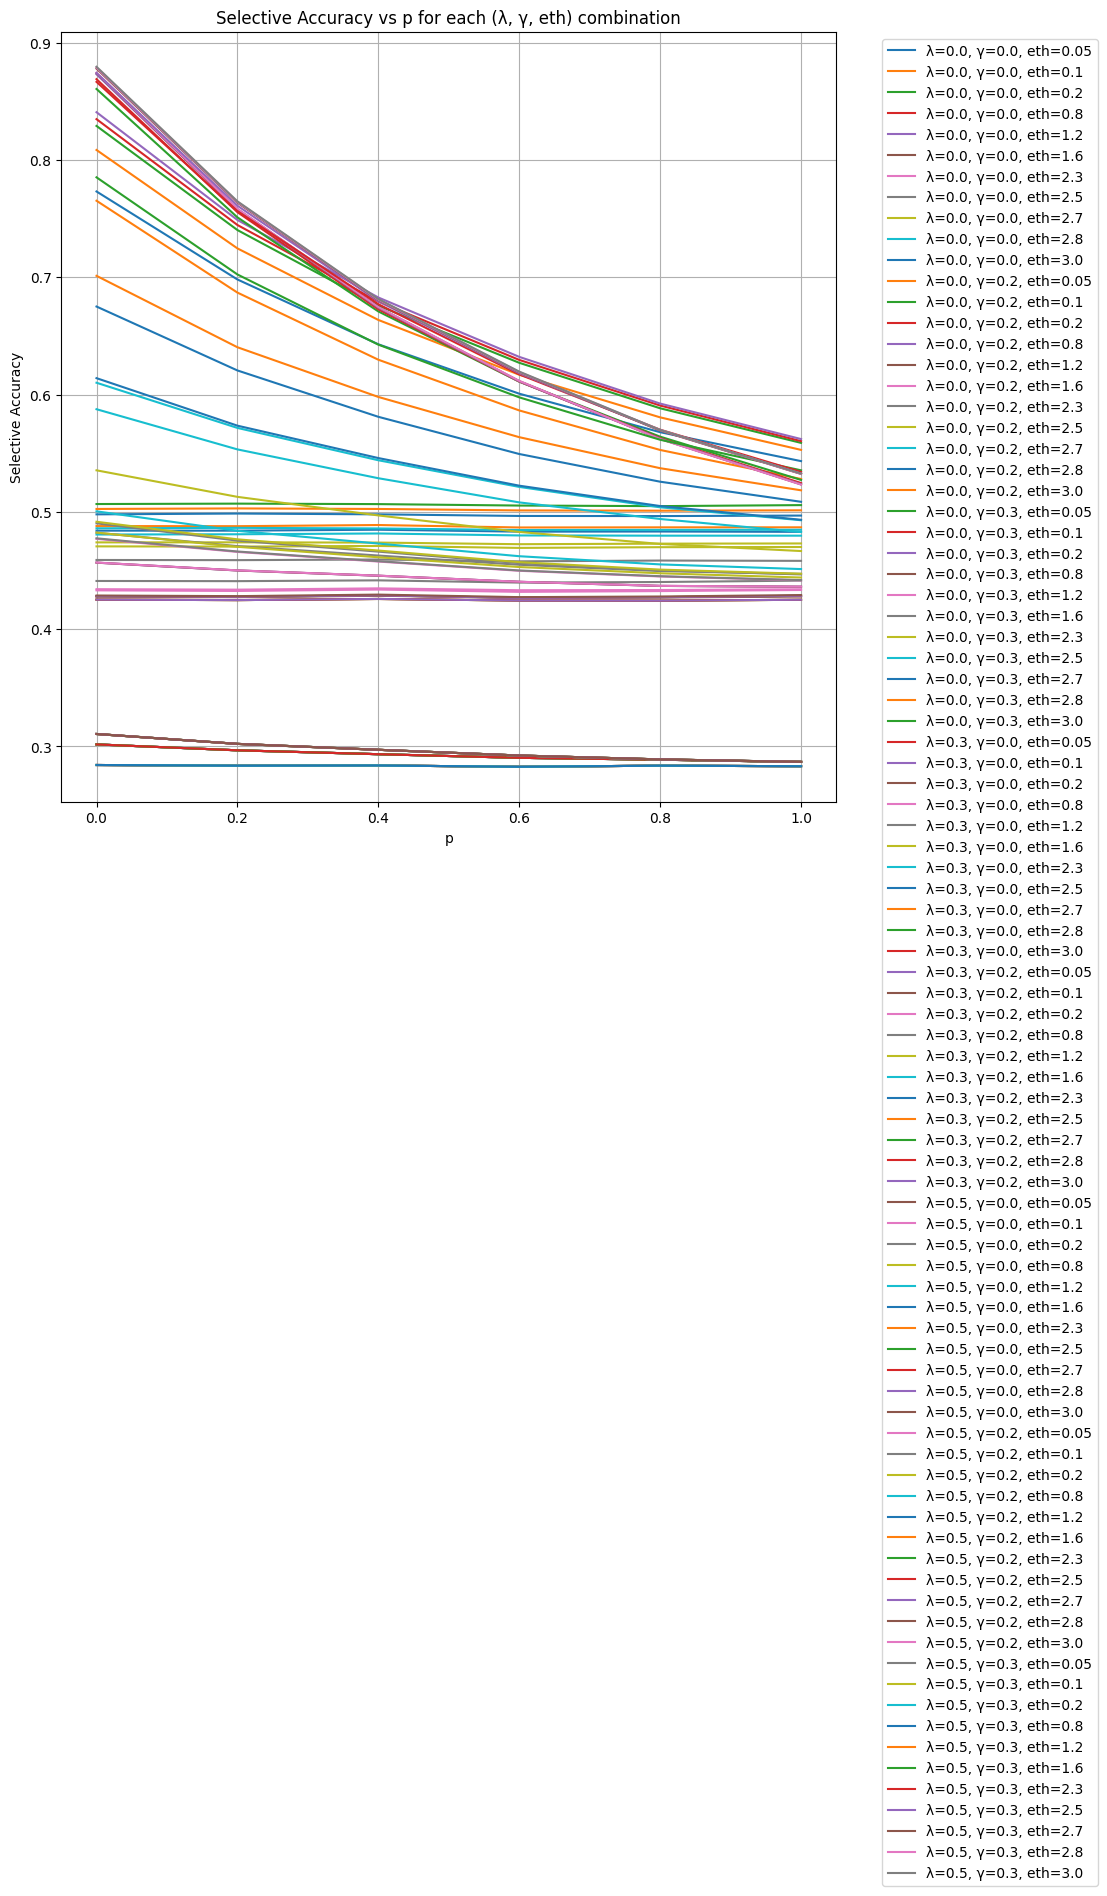

In [19]:
groups = filterted_df.groupby(["lambda", "gamma", "eth"])

plt.figure(figsize=(10, 10))

# Loop through each group and plot
for (lam, gam, eth), group in groups:
    plt.plot(
        group["p"],
        group["selective_acc"],
        label=f"λ={lam}, γ={gam}, eth={eth}"
    )

plt.xlabel("p")
plt.ylabel("Selective Accuracy")
plt.title("Selective Accuracy vs p for each (λ, γ, eth) combination")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside
plt.grid(True)
plt.tight_layout()
plt.show()

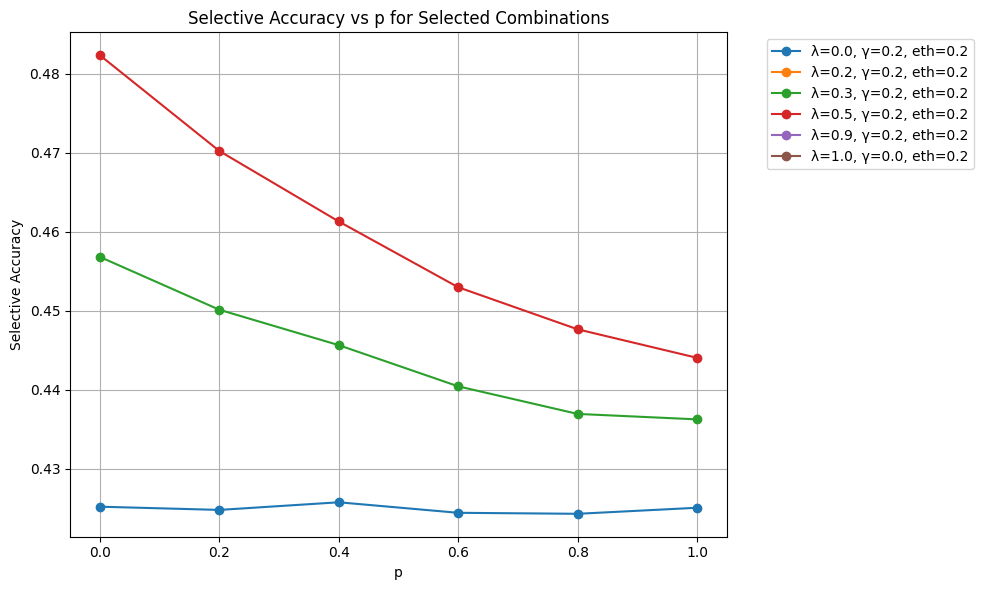

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Example dataframe
# df = pd.read_csv("your_data.csv")

# --- List of parameter combinations you want to plot ---
# Each tuple is (lambda, gamma, eth)
# selected_combinations = [
#     (0.0, 0.2, 3.0),
#     (0.2, 0.2, 3.0),
#     (0.3, 0.2, 3.0),
#     (0.5, 0.2, 3.0),
#     (0.9, 0.2, 3.0),
#     (1.0, 0.0, 1.6),
# ]
eth_value = 0.2
selected_combinations = [
    (0.0, 0.2, eth_value),
    (0.2, 0.2, eth_value),
    (0.3, 0.2, eth_value),
    (0.5, 0.2, eth_value),
    (0.9, 0.2, eth_value),
    (1.0, 0.0,eth_value),
]

plt.figure(figsize=(10, 6))

for lam, gam, eth in selected_combinations:
    # Filter for this combination
    filtered_df = filterted_df[
        (filterted_df["lambda"] == lam) &
        (filterted_df["gamma"] == gam) &
        (filterted_df["eth"] == eth)
    ]
    
    # Plot
    plt.plot(
        filtered_df["p"], 
        filtered_df["selective_acc"], 
        marker='o',
        label=f"λ={lam}, γ={gam}, eth={eth}"
    )

plt.xlabel("p")
plt.ylabel("Selective Accuracy")
plt.title("Selective Accuracy vs p for Selected Combinations")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()


In [28]:
filterted_df['eth'].unique()

array([0.2 , 2.8 , 3.  , 0.1 , 2.3 , 0.8 , 1.6 , 2.5 , 2.7 , 1.2 , 0.05])

# Final Results comparison with different gamma and lambda and eth

In [7]:
import glob
import pandas as pd
import numpy as np
import os


lambda_values = [0.5, 0.8, 1.0,0.0, 0.2,0.3,0.9]
eth_values = [0.05,0.1,0.2,0.8,1.2,1.6,2.3, 2.5, 2.7, 2.8, 3.0]
gamma_values = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

for eth_value in eth_values:
    for gamma_value in gamma_values:
        for lambda_value in lambda_values:

            exp_folder_name = "results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_801_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05"
            filename = f"splitgp_combined_results_eth_{eth_value}_gamma_{gamma_value}_lambda_split_{lambda_value}.csv"

            file_path = os.path.join(exp_folder_name, filename)

            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df = df[['p',
                         'full_acc',
                         'client_acc',
                         'selective_acc',
                         'gamma',
                         'lambda',
                         'eth']
                            ]
                print(f"Data from {filename}:")
                print(df)
            else:
                print(f"File {filename} does not exist in the directory {exp_folder_name}.")


Data from splitgp_combined_results_eth_0.05_gamma_0.0_lambda_split_0.5.csv:
     p  full_acc  client_acc  selective_acc  gamma  lambda   eth
0  0.0  0.310620    0.151240       0.310620    0.0     0.5  0.05
1  0.2  0.302208    0.149175       0.302208    0.0     0.5  0.05
2  0.4  0.297200    0.150107       0.297200    0.0     0.5  0.05
3  0.6  0.292344    0.148906       0.292344    0.0     0.5  0.05
4  0.8  0.289044    0.148106       0.289044    0.0     0.5  0.05
5  1.0  0.286815    0.147895       0.286815    0.0     0.5  0.05
File splitgp_combined_results_eth_0.05_gamma_0.0_lambda_split_0.8.csv does not exist in the directory results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_801_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05.
File splitgp_combined_results_eth_0.05_gamma_0.0_lambda_split_1.0.csv does not exist in the directory results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_801_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05.

In [11]:
import glob
import pandas as pd
import numpy as np
import os


lambda_values = [0.5, 0.8, 1.0,0.0, 0.2,0.3,0.9]
eth_values = [0.05,0.1,0.2,0.8,1.2,1.6,2.3, 2.5, 2.7, 2.8, 3.0]
gamma_values = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]


exp_folder_name = "results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05"
# filename = f"splitgp_combined_results_eth_{eth_value}_gamma_{gamma_value}_lambda_split_{lambda_value}.csv"

file_paths =  glob.glob(os.path.join(exp_folder_name, f"*.csv"))
for file_path in file_paths:

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df = df[['p',
                 'full_acc',
                 'client_acc',
                 'selective_acc',
                 # 'gamma',
                 # 'lambda',
                 # 'eth'
                 ]
                    ]
        print(f"Data from {file_path}:")
        print(df)
    else:
        print(f"File {file_path} does not exist in the directory {exp_folder_name}.")

Data from results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_2.80.csv:
     p  full_acc  client_acc  selective_acc
0  0.0  0.402750    0.816280       0.810510
1  0.2  0.396700    0.747567       0.742775
2  0.4  0.391714    0.698421       0.694471
3  0.6  0.386831    0.660656       0.656787
4  0.8  0.384044    0.630450       0.627061
5  1.0  0.381695    0.608355       0.605185
Data from results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_0.10.csv:
     p  full_acc  client_acc  selective_acc
0  0.0  0.402480    0.816290       0.402500
1  0.2  0.396417    0.747583       0.396433
2  0.4  0.391457    0.698443       0.391471
3  0.6  0.386700    0.660731       0.386713
4  0.8  0.383878    0.630428       0.383889
5  1.0  0.381470    0.608350       0.381480
Data from results/spli

In [4]:
import glob
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


def plot_selective_acc_by_eth(exp_folder_name: str):

    file_paths = glob.glob(os.path.join(exp_folder_name, "*.csv"))
    all_data = []

    for file_path in file_paths:
        filename = os.path.basename(file_path)

        # Extract ETH value from filename (e.g., splitgp_combined_results_eth_2.80.csv)
        try:
            eth_value = float(filename.split("_eth_")[-1].replace(".csv", ""))
        except Exception:
            print(f"⚠️ Could not extract ETH value from {filename}")
            continue

        print("file path",file_path)
        df = pd.read_csv(file_path)
        required_cols = ['p', 'full_acc', 'client_acc', 'selective_acc']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠️ Missing columns in {filename}, skipping.")
            continue

        df = df[required_cols].copy()
        df["ETH"] = eth_value
        all_data.append(df)

    # ------------------------
    # Combine all ETHs into one DataFrame
    # ------------------------
    if not all_data:
        print("❌ No valid CSV files found.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.sort_values(by="ETH", inplace=True)

    # ------------------------
    # Create plots (each with its own axes)
    # ------------------------
    unique_eth = sorted(combined_df["ETH"].unique())
    ncols = 3
    nrows = int(np.ceil(len(unique_eth) / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows), sharex=False, sharey=False)
    axes = axes.flatten()

    for i, eth in enumerate(unique_eth):
        ax = axes[i]
        subset = combined_df[combined_df["ETH"] == eth]

        ax.plot(subset["p"], subset["selective_acc"], label="Selective Acc", marker="^", color="tab:blue")

        ax.set_title(f"ETH = {eth}")
        ax.set_xlabel("p")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0.5, 0.9)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(fontsize=8)

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Selective Accuracy vs p for Different ETH Values", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


# Example usage:
path = "results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05"
path = "results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_801_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05"
plot_selective_acc_by_eth(path)


⚠️ Could not extract ETH value from splitgp_combined_results_eth_0.20_gamma_0.0_lambda_split_0.0.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_2.80_gamma_0.0_lambda_split_0.3.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_3.00_gamma_0.0_lambda_split_0.3.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_0.10_gamma_0.2_lambda_split_0.3.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_2.30_gamma_0.2_lambda_split_0.0.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_2.30_gamma_0.0_lambda_split_0.5.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_2.80_gamma_0.2_lambda_split_0.0.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_0.20_gamma_0.4_lambda_split_0.3.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_0.80_gamma_0.2_lambda_split_0.3.csv
⚠️ Could not extract ETH value from splitgp_combined_results_eth_1.60_gamma_0.3_lambda_spli

✅ File: splitgp_combined_results_eth_2.80.csv | ETH = 2.8
✅ File: splitgp_combined_results_eth_0.10.csv | ETH = 0.1
✅ File: splitgp_combined_results_eth_2.70.csv | ETH = 2.7
✅ File: splitgp_combined_results_eth_2.00.csv | ETH = 2.0
✅ File: splitgp_combined_results_eth_0.40.csv | ETH = 0.4
✅ File: splitgp_combined_results_eth_3.00.csv | ETH = 3.0
✅ File: splitgp_combined_results_eth_1.60.csv | ETH = 1.6
✅ File: splitgp_combined_results_eth_0.05.csv | ETH = 0.05
✅ File: splitgp_combined_results_eth_0.20.csv | ETH = 0.2
✅ File: splitgp_combined_results_eth_1.20.csv | ETH = 1.2
✅ File: splitgp_combined_results_eth_2.50.csv | ETH = 2.5
✅ File: splitgp_combined_results_eth_2.30.csv | ETH = 2.3
✅ File: splitgp_combined_results_eth_0.80.csv | ETH = 0.8


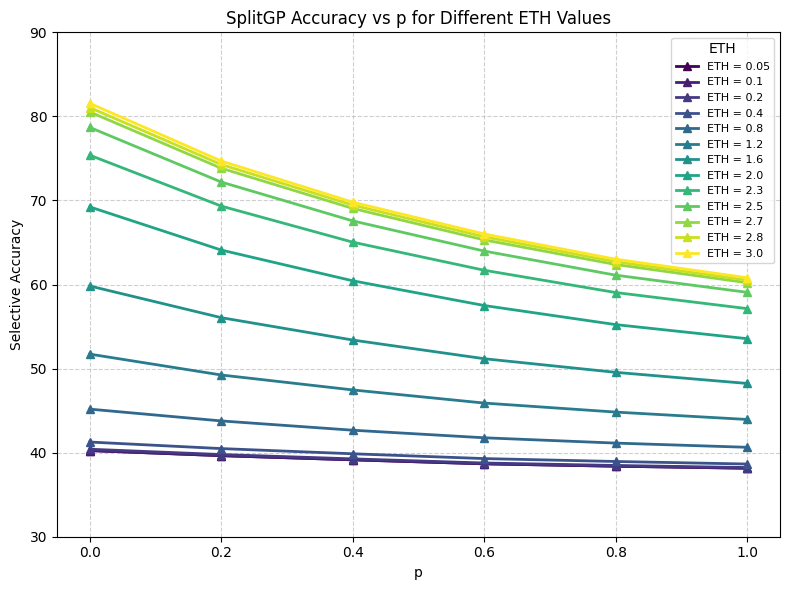

In [43]:
import glob
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def plot_selective_acc_by_eth(exp_folder_name: str):
    """
    Reads CSVs in the given folder, extracts ETH values from filenames,
    and plots selective accuracy vs p for each ETH on the same figure (unique colors).
    """

    file_paths = glob.glob(os.path.join(exp_folder_name, "*.csv"))
    all_data = []

    for file_path in file_paths:
        filename = os.path.basename(file_path)

        # ✅ Extract ETH value
        match = re.search(r"_eth_([0-9]*\.?[0-9]+)", filename)
        if not match:
            print(f"⚠️ Could not extract ETH value from {filename}")
            continue

        eth_value = float(match.group(1))
        print(f"✅ File: {filename} | ETH = {eth_value}")

        # Read CSV
        df = pd.read_csv(file_path)
        required_cols = ['p', 'full_acc', 'client_acc', 'selective_acc']
        if not all(col in df.columns for col in required_cols):
            print(f"⚠️ Missing columns in {filename}, skipping.")
            continue

        df = df[required_cols].copy()
        df["ETH"] = eth_value
        all_data.append(df)

    # ------------------------
    # Combine all ETHs into one DataFrame
    # ------------------------
    if not all_data:
        print("❌ No valid CSV files found.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)
    combined_df.sort_values(by=["ETH", "p"], inplace=True)

    # ------------------------
    # Plot all ETHs on the same figure (unique colors)
    # ------------------------
    plt.figure(figsize=(8, 6))

    unique_eths = sorted(combined_df["ETH"].unique())
    colors = cm.viridis(np.linspace(0, 1, len(unique_eths)))  # 🌈 distinct colors

    for color, eth in zip(colors, unique_eths):
        subset = combined_df[combined_df["ETH"] == eth].sort_values(by="p")
        plt.plot(
            subset["p"],
            subset["selective_acc"]*100,
            marker="^",
            label=f"ETH = {eth}",
            color=color,
            linewidth=2,
        )

    plt.title("SplitGP Accuracy vs p for Different ETH Values")
    plt.xlabel("p")
    plt.ylabel("Selective Accuracy")
    plt.ylim(30, 90)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="ETH", fontsize=8)
    plt.tight_layout()
    plt.savefig("SplitGP_combined.png", dpi=300)
    plt.show()


# Example usage
path = "results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05"
plot_selective_acc_by_eth(path)


     p  p.1  full_acc  client_acc  selective_acc  gamma  lambda  eth
0  0.0  0.0  0.371900    0.542600       0.541800    0.5     0.0  3.0
1  0.2  0.2  0.372108    0.542575       0.541767    0.5     0.0  3.0
2  0.4  0.4  0.371757    0.543107       0.542371    0.5     0.0  3.0
3  0.6  0.6  0.370044    0.541100       0.540225    0.5     0.0  3.0
4  0.8  0.8  0.370144    0.540350       0.539639    0.5     0.0  3.0


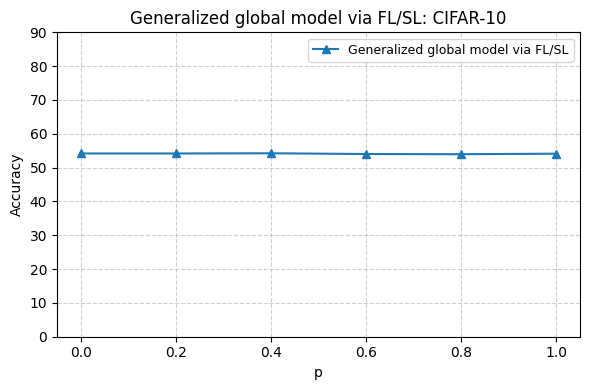

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# Path to your CSV file
file_path = "results/splitgp_vgg11_results_CIFAR10_method_splitgp_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.2_ETH_0.05/splitgp_combined_results_eth_2.70.csv"

# multi-exit
file_path = "results/splitgp_vgg11_results_CIFAR10_method_multi-exit_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.0_ETH_0.2/multi-exit_combined_results_eth_3.00_gamma_0.5_lambda_split_0.0.csv"

# generalized global model
file_path = "results/splitgp_vgg11_results_CIFAR10_method_multi-exit_rounds_800_clients_50_model_split_index_11_gamma_0.5_lambda_split_0.0_ETH_0.2/multi-exit_combined_results_eth_3.00_gamma_0.5_lambda_split_0.0.csv"

# Extract ETH value from filename (optional, for the title)
filename = os.path.basename(file_path)
match = re.search(r"_eth_([0-9]*\.?[0-9]+)", filename)
eth_value = float(match.group(1)) if match else None

# Read CSV
df = pd.read_csv(file_path)
print(df.head())

# Check required columns
required_cols = ['p', 'selective_acc']
if not all(col in df.columns for col in required_cols):
    raise ValueError(f"Missing required columns. Found: {df.columns.tolist()}")

# Sort by p (important for smooth plotting)
df = df.sort_values(by="p")

# Create plot
plt.figure(figsize=(6, 4))
plt.plot(df["p"], df["selective_acc"]*100, label="Generalized global model via FL/SL", marker="^", color="tab:blue")

# Title and labels
plt.title(f"Generalized global model via FL/SL: CIFAR-10")
plt.xlabel("p")
plt.ylabel("Accuracy")
plt.ylim(0, 90)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()
